<a href="https://colab.research.google.com/github/afonsoegmar/E-commerce/blob/master/RedeMPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


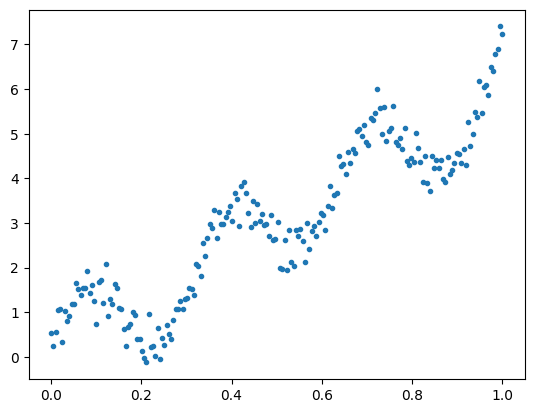

(200,)


In [2]:
np.random.seed(0)
X = np.arange(0,20,0.1)
Y = np.sin(X) + 0.3*np.random.randn(X.shape[0]) + 0.3*X

X = X / np.max(X)
# Y = Y / np.max(Y)
plt.plot(X,Y, '.')
plt.show()
print(X.shape)

(30, 1)
(30, 1)
(140, 1)


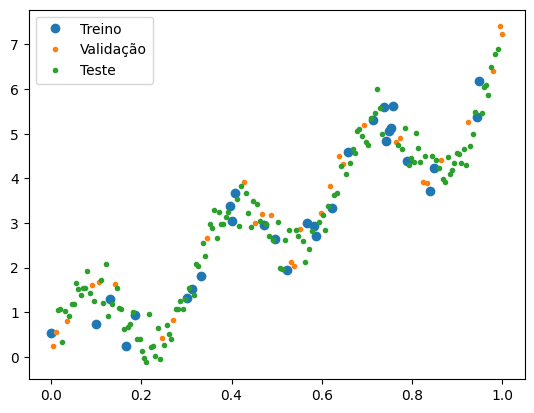

In [3]:
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

# Separação desenvolvimento (30) e teste (70)
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.7, random_state=3)

# Separação treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.5, random_state=3)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

plt.plot(X_train, Y_train, 'o', label='Treino')
plt.plot(X_val, Y_val, '.', label='Validação')
plt.plot(X_test, Y_test, '.', label='Teste')
plt.legend()
plt.show()

In [4]:
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(Y_train)

x_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(Y_val)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(Y_test)

In [5]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,output_dim),
        )
    def forward(self,x):
        out =  self.rede(x)
        return out

In [6]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes

modelo = MLP(input_dim,output_dim)


In [7]:
from torchsummary import summary

print(modelo)
summary(modelo, (1,1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]           1,024
              Tanh-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              Tanh-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
              Tanh-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
              Tanh-8  

In [8]:
eta = 0.02
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(modelo.parameters(),lr=eta)

In [9]:
# verificando disponibilidade da gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
def train_network(model,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses):
    for epoch in range(num_epochs):
        # zerando os gradientes da época anterior
        optimizer.zero_grad()

        # fase de propagação
        output_train = model(x_train)

        # cálculo do erro (função de custo - loss function)
        loss_train = loss_function(output_train, y_train)

        # fase de retroprogação
        loss_train.backward()

        # atualização dos pesos da rede
        optimizer.step()

        # avaliando o modelo com o conjunto de validação
        output_val = model(x_val)
        loss_val = loss_function(output_val,y_val)

        train_losses[epoch] = loss_train.item()
        val_losses[epoch] = loss_val.item()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Erro Treino: {loss_train.item():.4f},  Erro Validação: {loss_val.item():.3f}")

In [11]:
num_epochs = 10000
train_losses = np.zeros(num_epochs)
val_losses  = np.zeros(num_epochs)

train_network(modelo,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses)

Epoch 500/10000, Erro Treino: 0.4745,  Erro Validação: 0.712
Epoch 1000/10000, Erro Treino: 0.3862,  Erro Validação: 0.795
Epoch 1500/10000, Erro Treino: 0.3083,  Erro Validação: 0.769
Epoch 2000/10000, Erro Treino: 0.2204,  Erro Validação: 0.680
Epoch 2500/10000, Erro Treino: 0.1778,  Erro Validação: 0.589
Epoch 3000/10000, Erro Treino: 0.0814,  Erro Validação: 0.299
Epoch 3500/10000, Erro Treino: 0.0685,  Erro Validação: 0.252
Epoch 4000/10000, Erro Treino: 0.0657,  Erro Validação: 0.242
Epoch 4500/10000, Erro Treino: 0.0642,  Erro Validação: 0.237
Epoch 5000/10000, Erro Treino: 0.0634,  Erro Validação: 0.235
Epoch 5500/10000, Erro Treino: 0.0631,  Erro Validação: 0.236
Epoch 6000/10000, Erro Treino: 0.0626,  Erro Validação: 0.236
Epoch 6500/10000, Erro Treino: 0.0621,  Erro Validação: 0.235
Epoch 7000/10000, Erro Treino: 0.0616,  Erro Validação: 0.233
Epoch 7500/10000, Erro Treino: 0.0611,  Erro Validação: 0.232
Epoch 8000/10000, Erro Treino: 0.0607,  Erro Validação: 0.231
Epoch 850

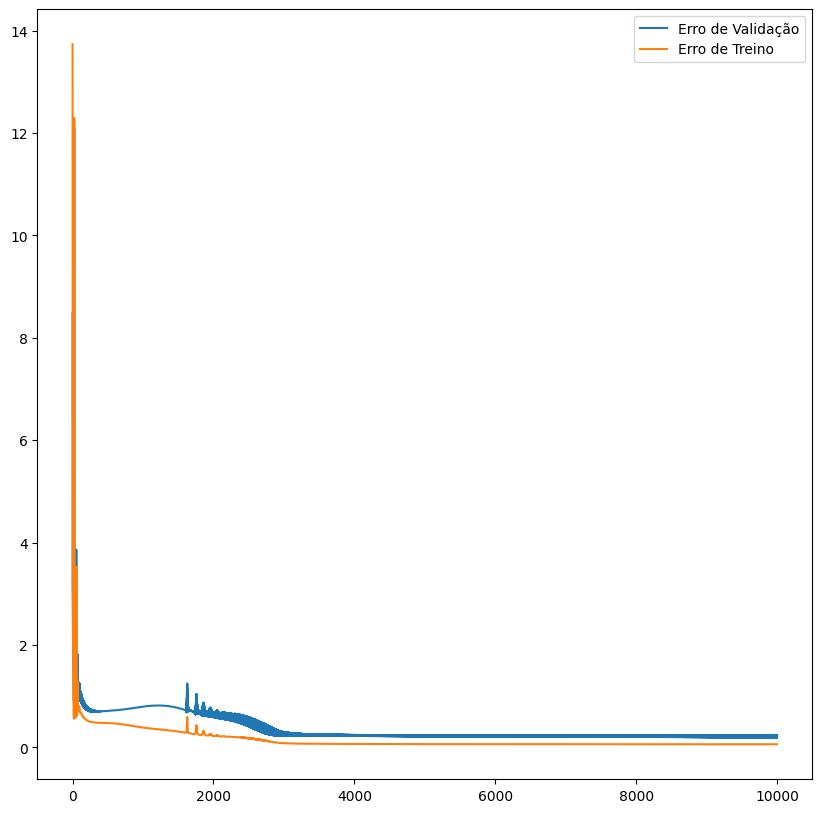

In [12]:
plt.figure(figsize=(10,10))
plt.plot(val_losses, label='Erro de Validação')
plt.plot(train_losses, label='Erro de Treino')
plt.legend()
plt.show()

In [13]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = modelo(x_train)
    predictions_val = modelo(x_val)
    predictions_test = modelo(x_test)

erro_train = loss_function(predictions_train,y_train)
erro_val = loss_function(predictions_val,y_val)
erro_test = loss_function(predictions_test,y_test)

print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

Erro de Treino: 0.059965331107378006
Erro de Validação: 0.23435385525226593
Erro de Teste: 0.25407204031944275


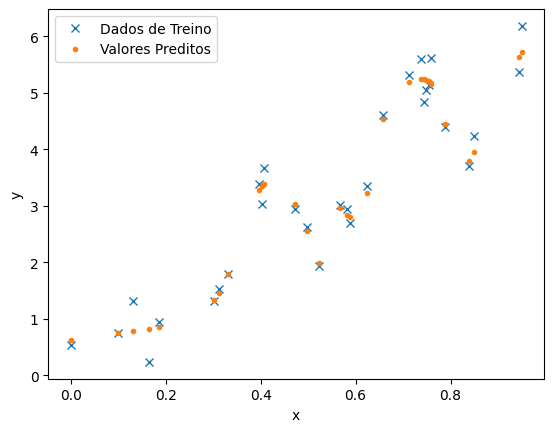

In [14]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

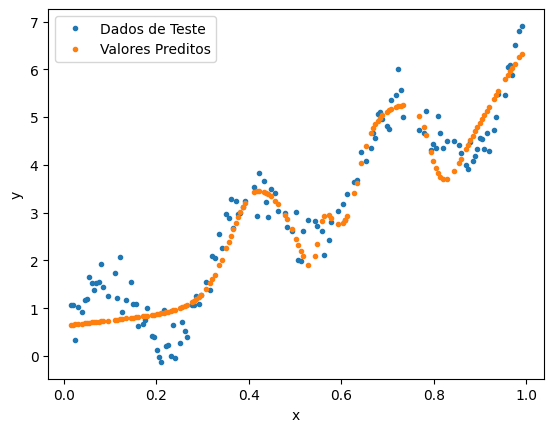

In [15]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

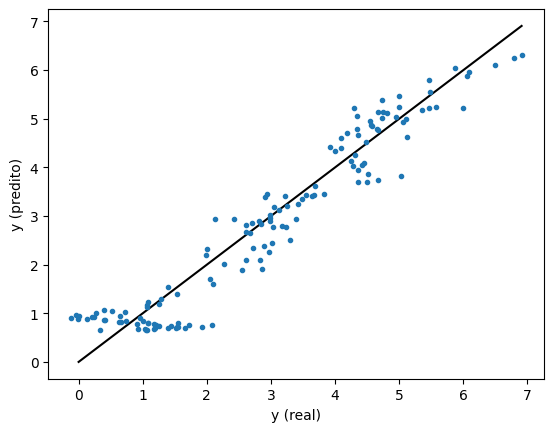

In [16]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

In [17]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo2 = MLP(input_dim,output_dim)

In [18]:
eta = 0.02
mom = 0.5 # momentum
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(modelo2.parameters(),lr=eta, momentum=mom)
# optimizer = torch.optim.SGD(modelo2.parameters(),lr=eta)


In [19]:
num_epochs = 10000
train_losses2 = np.zeros(num_epochs)
val_losses2  = np.zeros(num_epochs)

train_network(modelo2,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses2,val_losses2)

Epoch 500/10000, Erro Treino: 0.4365,  Erro Validação: 0.752
Epoch 1000/10000, Erro Treino: 0.2162,  Erro Validação: 0.610
Epoch 1500/10000, Erro Treino: 0.0863,  Erro Validação: 0.245
Epoch 2000/10000, Erro Treino: 0.0649,  Erro Validação: 0.199
Epoch 2500/10000, Erro Treino: 0.0619,  Erro Validação: 0.195
Epoch 3000/10000, Erro Treino: 0.0630,  Erro Validação: 0.179
Epoch 3500/10000, Erro Treino: 0.0595,  Erro Validação: 0.193
Epoch 4000/10000, Erro Treino: 0.0589,  Erro Validação: 0.193
Epoch 4500/10000, Erro Treino: 0.0584,  Erro Validação: 0.192
Epoch 5000/10000, Erro Treino: 0.0581,  Erro Validação: 0.192
Epoch 5500/10000, Erro Treino: 0.0577,  Erro Validação: 0.189
Epoch 6000/10000, Erro Treino: 0.0574,  Erro Validação: 0.186
Epoch 6500/10000, Erro Treino: 0.0718,  Erro Validação: 0.163
Epoch 7000/10000, Erro Treino: 0.0566,  Erro Validação: 0.180
Epoch 7500/10000, Erro Treino: 0.0561,  Erro Validação: 0.177
Epoch 8000/10000, Erro Treino: 0.0555,  Erro Validação: 0.175
Epoch 850

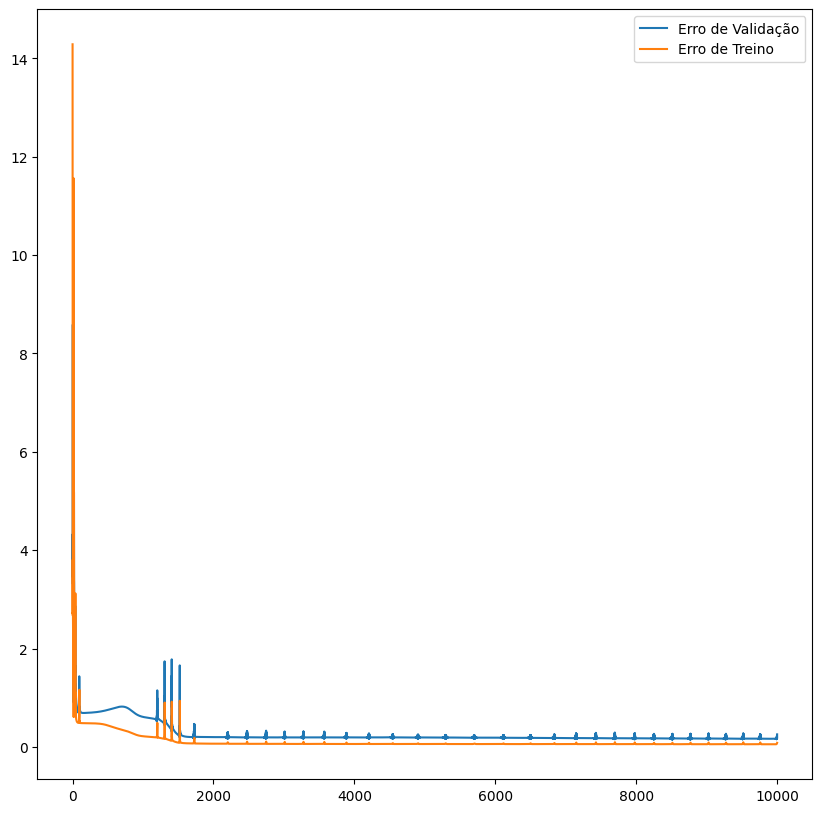

In [20]:
plt.figure(figsize=(10,10))
plt.plot(val_losses2, label='Erro de Validação')
plt.plot(train_losses2, label='Erro de Treino')
plt.legend()
plt.show()

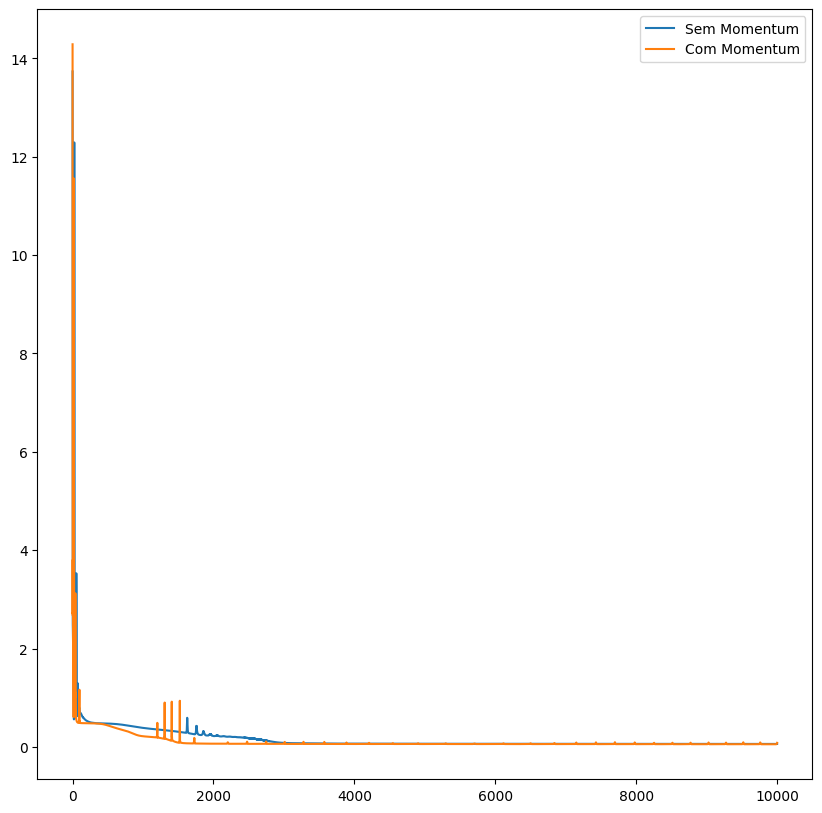

In [21]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Sem Momentum')
plt.plot(train_losses2, label='Com Momentum')
plt.legend()
plt.show()

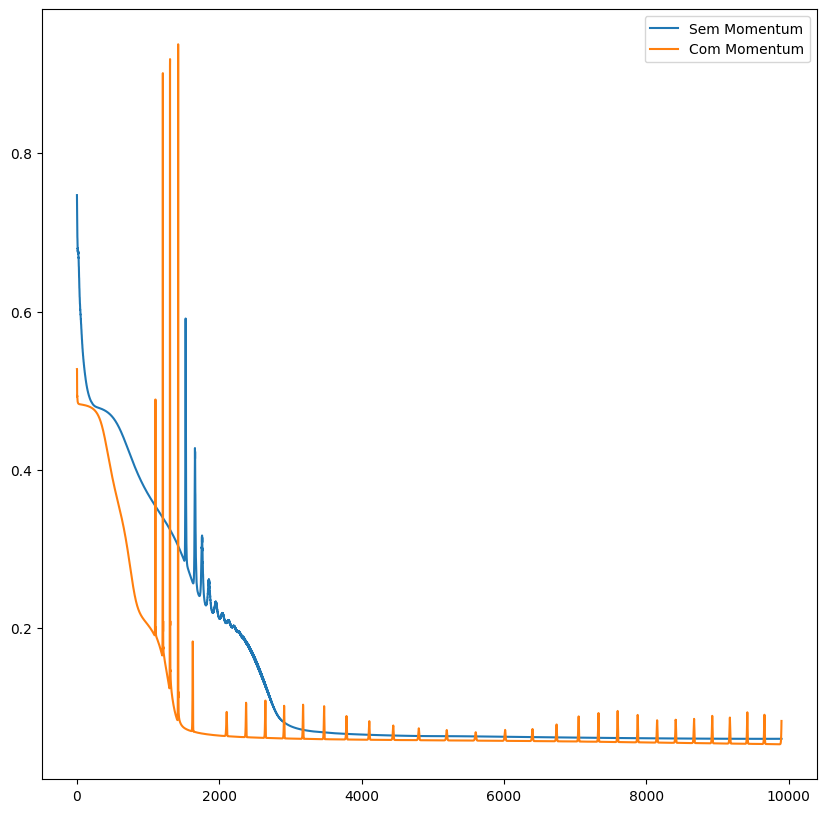

In [22]:
plt.figure(figsize=(10,10))
plt.plot(train_losses[100:], label='Sem Momentum')
plt.plot(train_losses2[100:], label='Com Momentum')
plt.legend()
plt.show()

In [23]:
predictions_train2 = []
predictions_val2 = []
predictions_test2 =  []
with torch.no_grad():
    predictions_train2 = modelo2(x_train)
    predictions_val2 = modelo2(x_val)
    predictions_test2 = modelo2(x_test)

erro_train2 = loss_function(predictions_train2,y_train)
erro_val2 = loss_function(predictions_val2,y_val)
erro_test2 = loss_function(predictions_test2,y_test)

print(f"Erro de Treino: {erro_train2}")
print(f"Erro de Validação: {erro_val2}")
print(f"Erro de Teste: {erro_test2}")

Erro de Treino: 0.089365154504776
Erro de Validação: 0.25472113490104675
Erro de Teste: 0.23927241563796997


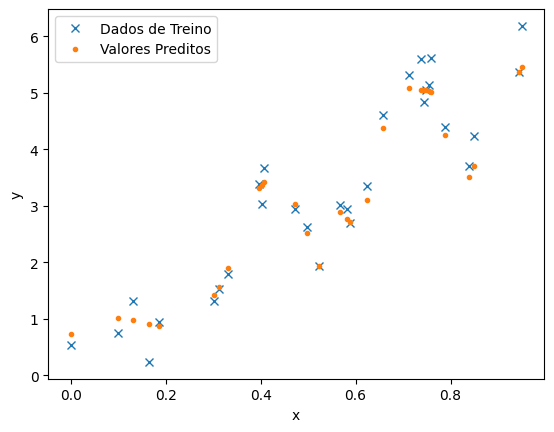

In [24]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train2, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

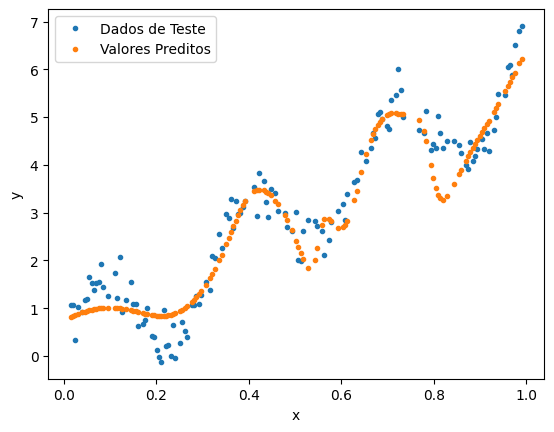

In [25]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test2, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

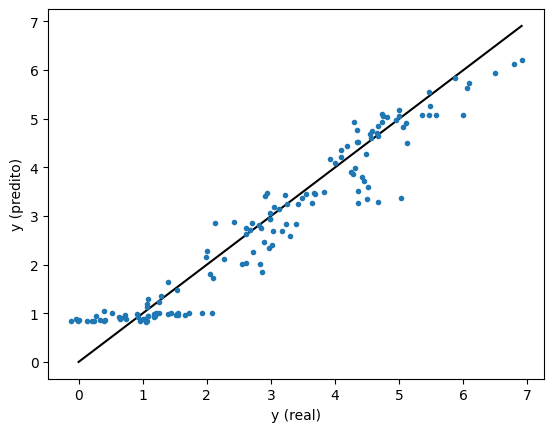

In [26]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test2, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

In [27]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo3 = MLP(input_dim,output_dim)

In [28]:
eta = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(modelo3.parameters(),lr=eta)

In [29]:
num_epochs = 10000
train_losses3 = np.zeros(num_epochs)
val_losses3  = np.zeros(num_epochs)

train_network(modelo3,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses3,val_losses3)

Epoch 500/10000, Erro Treino: 0.1167,  Erro Validação: 0.409
Epoch 1000/10000, Erro Treino: 0.0549,  Erro Validação: 0.341
Epoch 1500/10000, Erro Treino: 0.0539,  Erro Validação: 0.274
Epoch 2000/10000, Erro Treino: 0.0509,  Erro Validação: 0.259
Epoch 2500/10000, Erro Treino: 0.0182,  Erro Validação: 0.339
Epoch 3000/10000, Erro Treino: 0.0077,  Erro Validação: 0.417
Epoch 3500/10000, Erro Treino: 0.0076,  Erro Validação: 0.436
Epoch 4000/10000, Erro Treino: 0.0064,  Erro Validação: 0.482
Epoch 4500/10000, Erro Treino: 0.0176,  Erro Validação: 0.495
Epoch 5000/10000, Erro Treino: 0.0051,  Erro Validação: 0.448
Epoch 5500/10000, Erro Treino: 0.0099,  Erro Validação: 0.420
Epoch 6000/10000, Erro Treino: 0.0009,  Erro Validação: 0.410
Epoch 6500/10000, Erro Treino: 0.0006,  Erro Validação: 0.369
Epoch 7000/10000, Erro Treino: 0.0002,  Erro Validação: 0.340
Epoch 7500/10000, Erro Treino: 0.0221,  Erro Validação: 0.312
Epoch 8000/10000, Erro Treino: 0.0044,  Erro Validação: 0.467
Epoch 850

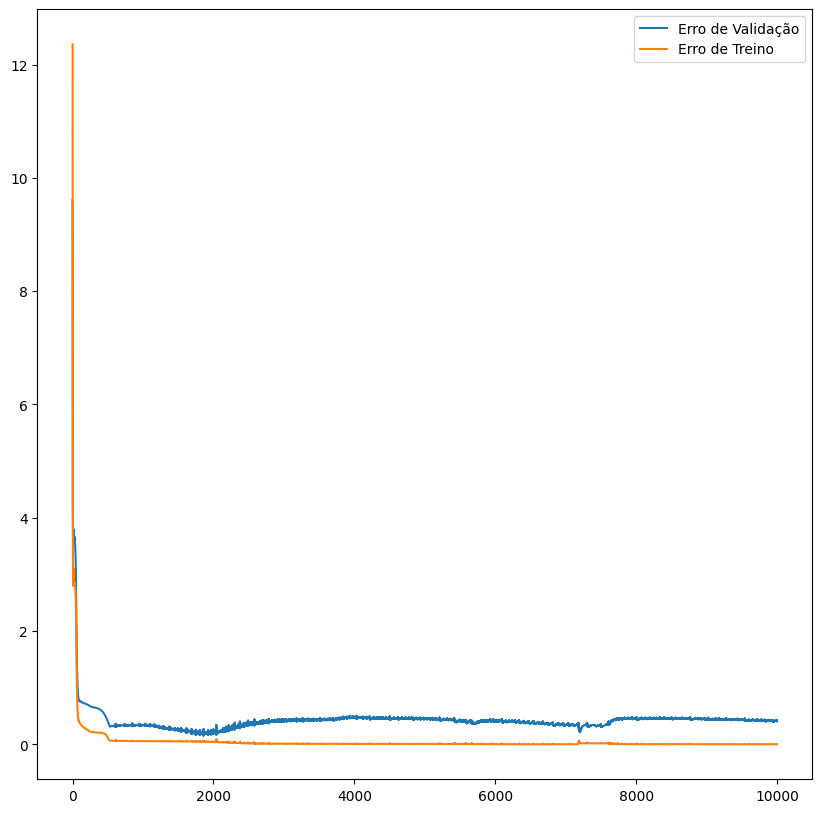

In [32]:
plt.figure(figsize=(10,10))
plt.plot(val_losses3, label='Erro de Validação')
plt.plot(train_losses3, label='Erro de Treino')
plt.legend()
plt.show()

In [34]:
predictions_train3 = []
predictions_val3 = []
predictions_test3 =  []
with torch.no_grad():
    predictions_train3 = modelo3(x_train)
    predictions_val3 = modelo3(x_val)
    predictions_test3 = modelo3(x_test)

erro_train3 = loss_function(predictions_train3,y_train)
erro_val3 = loss_function(predictions_val3,y_val)
erro_test3 = loss_function(predictions_test3,y_test)

print(f"Erro de Treino: {erro_train3}")
print(f"Erro de Validação: {erro_val3}")
print(f"Erro de Teste: {erro_test3}")

Erro de Treino: 0.0008554992964491248
Erro de Validação: 0.4058936834335327
Erro de Teste: 0.4550597071647644


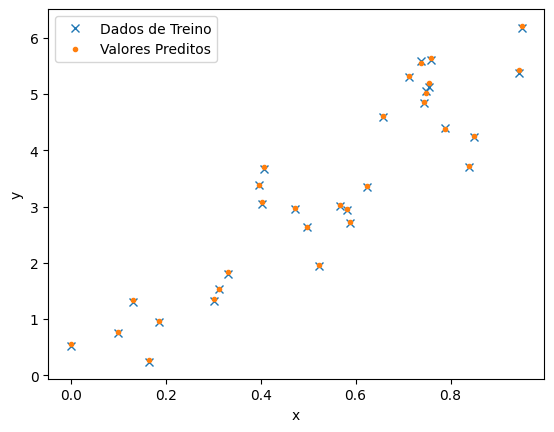

In [36]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train3, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

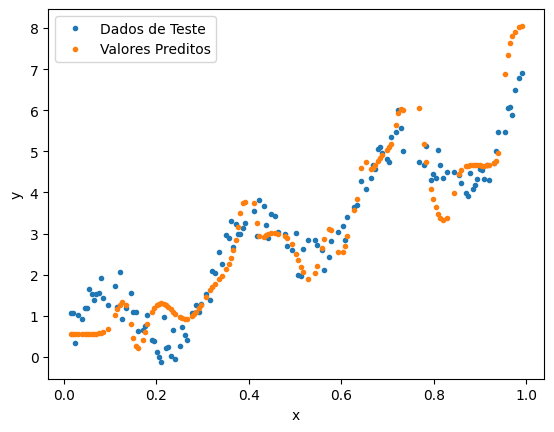

In [38]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test3, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

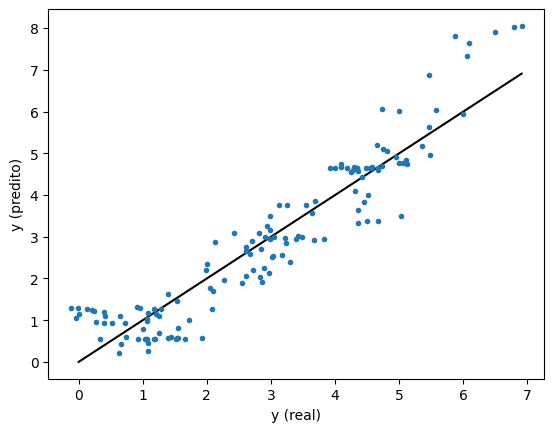

In [40]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test3, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

In [41]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo4B = MLP(input_dim,output_dim)

In [42]:
eta = 0.001
loss_function = nn.MSELoss()
# o parametro weight_decay adiciona o
# termo de regularização L2 à função de custo
optimizer = torch.optim.Adam(modelo4B.parameters(),
                             lr=eta,
                             weight_decay=0.5)

In [43]:
num_epochs = 3000
train_losses4B = np.zeros(num_epochs)
val_losses4B  = np.zeros(num_epochs)

train_network(modelo4B,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses4B,val_losses4B)

Epoch 500/3000, Erro Treino: 0.5574,  Erro Validação: 0.803
Epoch 1000/3000, Erro Treino: 0.5824,  Erro Validação: 0.763
Epoch 1500/3000, Erro Treino: 0.6436,  Erro Validação: 0.803
Epoch 2000/3000, Erro Treino: 0.6504,  Erro Validação: 0.809
Epoch 2500/3000, Erro Treino: 0.6486,  Erro Validação: 0.810
Epoch 3000/3000, Erro Treino: 0.6500,  Erro Validação: 0.808


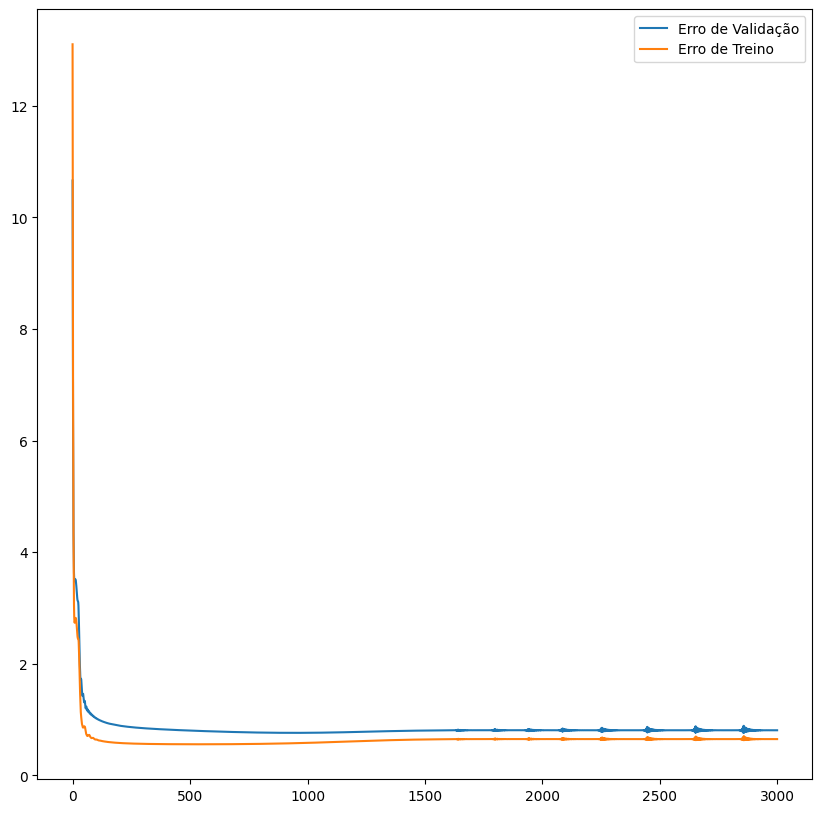

In [44]:
plt.figure(figsize=(10,10))
plt.plot(val_losses4B, label='Erro de Validação')
plt.plot(train_losses4B, label='Erro de Treino')
plt.legend()
plt.show()

In [45]:
predictions_train4B = []
predictions_val4B = []
predictions_test4B =  []
with torch.no_grad():
    predictions_train4B = modelo4B(x_train)
    predictions_val4B = modelo4B(x_val)
    predictions_test4B = modelo4B(x_test)

erro_train4B = loss_function(predictions_train4B,y_train)
erro_val4B = loss_function(predictions_val4B,y_val)
erro_test4B = loss_function(predictions_test4B,y_test)

print(f"Erro de Treino: {erro_train4B}")
print(f"Erro de Validação: {erro_val4B}")
print(f"Erro de Teste: {erro_test4B}")

Erro de Treino: 0.6500722169876099
Erro de Validação: 0.8083637952804565
Erro de Teste: 0.6923030018806458


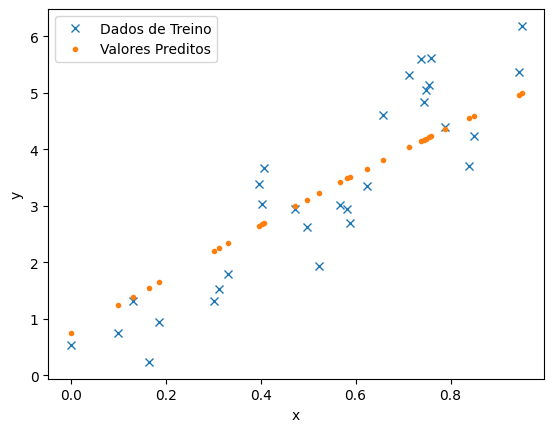

In [46]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train4B, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

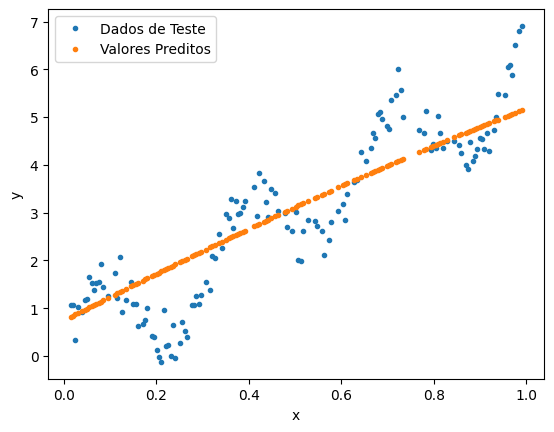

In [47]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test4B, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

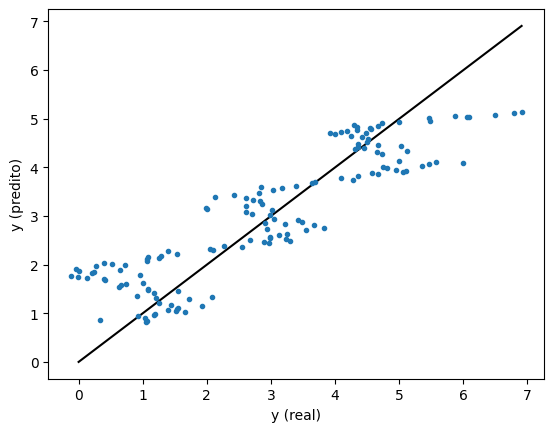

In [48]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test4B, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

In [49]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo4C = MLP(input_dim,output_dim)

In [50]:
eta = 0.001
loss_function = nn.MSELoss()
# o parametro weight_decay adiciona o
# termo de regularização L2 à função de custo
optimizer = torch.optim.Adam(modelo4C.parameters(),
                             lr=eta,
                             weight_decay=0.005)

In [51]:
num_epochs = 3000
train_losses4 = np.zeros(num_epochs)
val_losses4  = np.zeros(num_epochs)

train_network(modelo4C,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses4,val_losses4)

Epoch 500/3000, Erro Treino: 0.2246,  Erro Validação: 0.648
Epoch 1000/3000, Erro Treino: 0.1127,  Erro Validação: 0.361
Epoch 1500/3000, Erro Treino: 0.0777,  Erro Validação: 0.203
Epoch 2000/3000, Erro Treino: 0.0757,  Erro Validação: 0.178
Epoch 2500/3000, Erro Treino: 0.0844,  Erro Validação: 0.189
Epoch 3000/3000, Erro Treino: 0.0753,  Erro Validação: 0.161


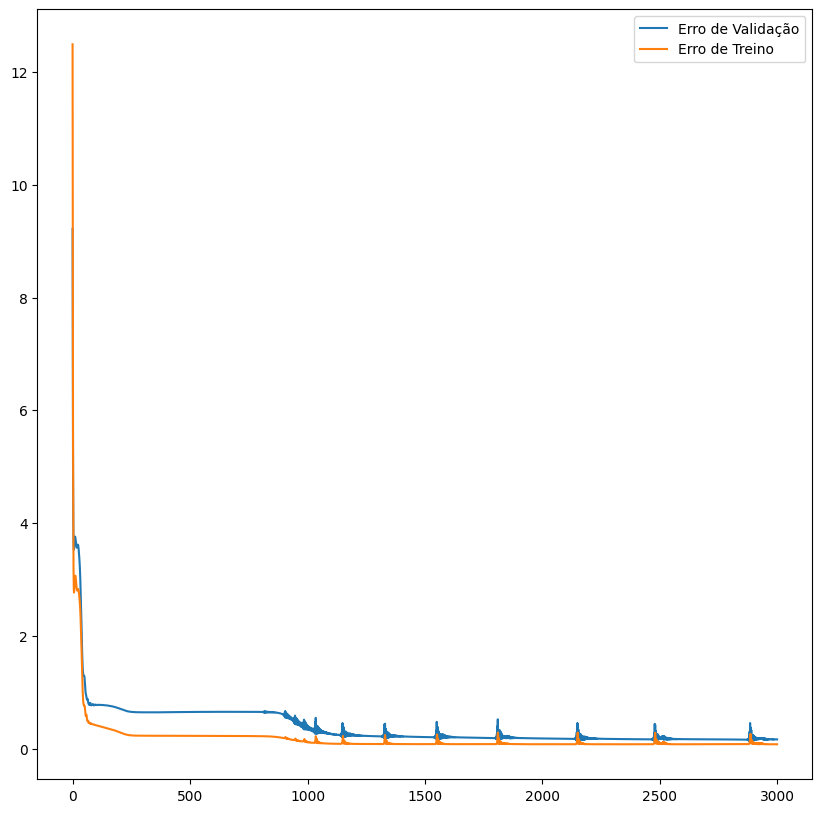

In [52]:
plt.figure(figsize=(10,10))
plt.plot(val_losses4, label='Erro de Validação')
plt.plot(train_losses4, label='Erro de Treino')
plt.legend()
plt.show()

In [53]:
predictions_train4 = []
predictions_val4 = []
predictions_test4 =  []
with torch.no_grad():
    predictions_train4 = modelo4C(x_train)
    predictions_val4 = modelo4C(x_val)
    predictions_test4 = modelo4C(x_test)

erro_train4 = loss_function(predictions_train4,y_train)
erro_val4 = loss_function(predictions_val4,y_val)
erro_test4 = loss_function(predictions_test4,y_test)

print(f"Erro de Treino: {erro_train4}")
print(f"Erro de Validação: {erro_val4}")
print(f"Erro de Teste: {erro_test4}")

Erro de Treino: 0.07526730000972748
Erro de Validação: 0.16126419603824615
Erro de Teste: 0.1750570833683014


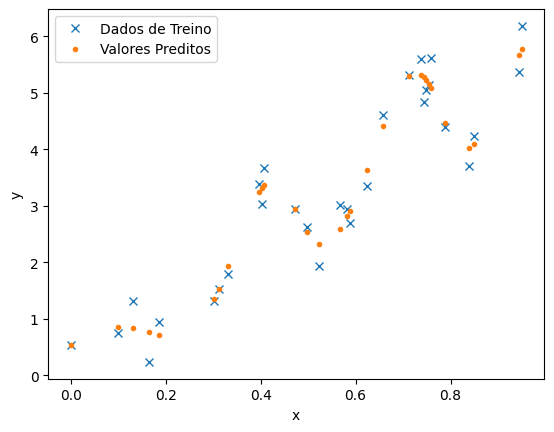

In [54]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train4, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

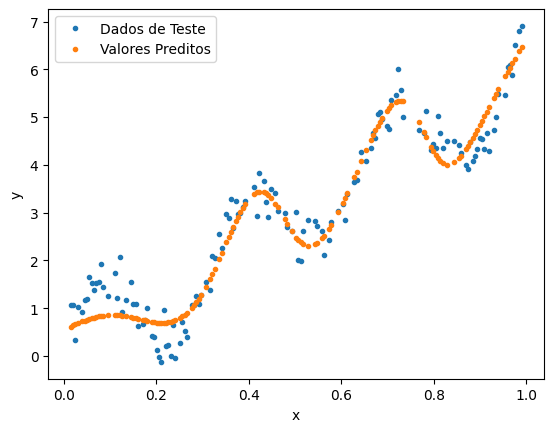

In [55]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test4, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

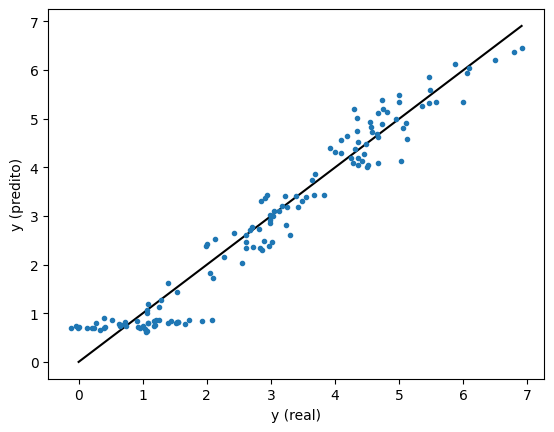

In [56]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test4, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()